In [17]:
import optuna
import plotly as plot
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataset import myDataset
from model import BaselineModel
from trainer import Trainer
from optimizer import Lion
import numpy as np
import random
import pandas as pd
import json
import nltk
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Generate elmo embedding

In [ ]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import json
import nltk
import random
import re                                 
import string
from cleantext import clean            
from nltk.corpus import stopwords           
from nltk.tokenize import TweetTokenizer 
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from tqdm import tqdm
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone',
        'time', 'date', 'number'],
    # terms that will be annotated
    # annotate={"hashtag", "allcaps", "elongated", "repeated",
    #     'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    segmenter="twitter", 
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for  
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)
class Dataset(object):
    def __init__(self, root_dir, max_seq_length, mode = "train", transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.max_seq_length = max_seq_length
        self.text_processor = text_processor
        self.data = self.read_data(root_dir)
        if self.mode != "test":
            self.labels = self.data.labels.tolist()
        self.classes = list(pd.read_csv("./HW1_dataset/sample_submission.csv").columns[1:])
        self.tweet_length,self.tweet_token = self.preprocess(self.data.tweet)
    def preprocess(self, tweets):
        def filter_words(x):
            x = re.sub(r'@[A-Za-z0-9_]+', '', x)
            # x = re.sub(r'[@#][^\s]*\s*|\s*[@#][^\s]*$', '', x)
            # x = re.sub(r'RT[\s]+', '', x)
            # x = re.sub(r"@([A-Za-z0-9_]{4,15})", r"@ <user>", x)
            # x = re.sub(r'\$', '', x)
            # x = re.sub(r'\+', '', x)
            # x = re.sub(r'\|', '', x)
            # x = re.sub(r'\.\.\.', '', x)
            x = x.replace("cant","can't")
            x = x.replace("wont","won't")
            x = x.replace("Im","I'm")
            x = x.replace("Ill","I'll")
            x = x.replace("Ive","I have")
            x = x.replace("I've","I have")
            x = x.replace("youre","you're")
            x = x.replace("theyre","they're")
            x = x.replace("thats","that's")
            x = x.replace("whats","what's")
            x = x.replace("dont","don't")
            x = x.replace("didnt","didn't")
            x = x.replace("doesnt","doesn't")
            x = x.replace(".","") 
            x = x.replace("nvm","never mind")
            x = clean(x, no_emoji=True, no_urls =True, no_numbers=True, replace_with_url="", replace_with_number="<NUMBER>")
            
            return x
        tweets = tweets.apply(lambda x : filter_words(x))
        tweet_token = tweets.apply(lambda x : self.text_processor.pre_process_doc(x))
        tweet_length = tweet_token.apply(lambda x : len(x))
        return tweet_length.to_numpy(), tweet_token.to_numpy()
    def padding(self,x):
        tweets = []
        for tweet in x:
            if len(tweet)>=self.max_seq_length:
                tweets.append(tweet[:self.max_seq_length])
            else:
                tweets.append(tweet + [""]*(self.max_seq_length-len(tweet)))
        return tweets
    def encode_label(self, labels):
        targets = np.zeros((len(labels),12))
        
        for i,label in enumerate(labels):
            for l in label:
                idx = self.classes.index(l)
                targets[i,idx] = 1
        return targets
    def read_data(self, root_dir):
        with open(root_dir, "r") as f:
            data = json.load(f)
        df =  pd.DataFrame(data)
        if self.mode != "test":
            df["labels"] = df.labels.apply(lambda x : list(x.keys()))
        return df 
    def get_data(self):
        self.tweet_token = self.padding(self.tweet_token)
        if self.mode != "test":
            return [self.tweet_token,self.encode_label(self.labels)]
        else:
            return [self.tweet_token]

In [ ]:
train_data_path = "./HW1_dataset/train.json"
val_data_path = "./HW1_dataset/val.json"
test_data_path = "./HW1_dataset/test.json"
train_dataset = Dataset(train_data_path, 55, mode = "train", transform=None)
val_dataset = Dataset(val_data_path, 55,mode = "val", transform=None)
test_dataset = Dataset(test_data_path, 55,mode = "test", transform=None)
train_data = train_dataset.get_data()
val_data = val_dataset.get_data()
test_data = test_dataset.get_data()
elmo = hub.load("https://tfhub.dev/google/elmo/3").signatures["default"]
seq_length = 55
embedding_dim = 1024
def generate_embeddings(data):
    embeddings = np.zeros((len(data[0]),seq_length,embedding_dim))
    for i in tqdm(range(len(data[0]))):
        try:
            data_tweet = tf.constant(data[0][i])
            embeddings[i] = tf.squeeze(elmo(data_tweet)["elmo"])
        except Exception as e:
            print(e)
            print("index:",i)
            print(data_tweet.shape)
            print(data_tweet)
    return embeddings

In [ ]:
train_embeddings = generate_embeddings(train_data)
val_embeddings = generate_embeddings(val_data)
test_embeddings = generate_embeddings(test_data)
train_data[1][5344] = np.zeros(12)
np.save("./elmo_embedding/new_preprocess_noAnotate_elmo_X_train.npy",train_embeddings)
np.save("./elmo_embedding/new_preprocess_noAnotate_elmo_X_val.npy",val_embeddings)
np.save("./elmo_embedding/new_preprocess_noAnotate_elmo_X_test.npy",test_embeddings)
np.save("./elmo_embedding/new_preprocess_noAnotate_elmo_y_train.npy",train_data[1])
np.save("./elmo_embedding/new_preprocess_noAnotate_elmo_y_val.npy",val_data[1])

# Build prediction dataset and prediction model for training 

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
import nltk
import random
import re                                 
import string
from cleantext import clean            
from nltk.corpus import stopwords     
from nltk.stem import PorterStemmer       
from nltk.tokenize import TweetTokenizer 
from textaugment import Translate, EDA
class myDataset(Dataset):
    def __init__(self, root_dir, vocab, max_seq_length, pad_token, unk_token, kind ="elmo",mode = "train", transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.stopwords = stopwords.words('english')
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.kind = kind
        self.max_seq_length = max_seq_length
        self.data = self.read_data(root_dir)              
        self.tweets = self.preprocess(self.data.tweet)
        if self.mode != "test":
            self.labels = self.data.labels.tolist()
        self.classes = list(pd.read_csv("./HW1_dataset/sample_submission.csv").columns[1:])
        if self.kind =="elmo":
            self.train_embedding = np.load("./elmo_X_train.npy", allow_pickle=True)
            self.train_embedding = np.concatenate(self.train_embedding, axis=1)
            self.train_embedding = np.transpose(self.train_embedding, (1,0,2))
            self.test_embedding = np.load("./elmo_X_test.npy", allow_pickle=True)
            self.test_embedding = np.concatenate(self.test_embedding, axis=1)
            self.test_embedding = np.transpose(self.test_embedding, (1,0,2))
            self.val_embedding = np.load("./elmo_X_val.npy", allow_pickle=True)
            self.val_embedding = np.concatenate(self.val_embedding, axis=1)
            self.val_embedding = np.transpose(self.val_embedding, (1,0,2))
            self.train_label = np.load("./elmo_y_train.npy", allow_pickle=True)
            self.train_label = np.vstack(self.train_label)
            self.val_label = np.load("./elmo_y_val.npy", allow_pickle=True)
            self.val_label = np.vstack(self.val_label)
        elif self.kind == "elmo_new":
            self.train_embedding = np.load("./elmo_embedding/new_preprocess_elmo_X_train.npy", allow_pickle=True)
            self.val_embedding = np.load("./elmo_embedding/new_preprocess_elmo_X_val.npy", allow_pickle=True)
            self.test_embedding = np.load("./elmo_embedding/new_preprocess_elmo_X_test.npy", allow_pickle=True)
            self.train_label = np.load("./elmo_embedding/new_preprocess_elmo_y_train.npy", allow_pickle=True)
            self.val_label = np.load("./elmo_embedding/new_preprocess_elmo_y_val.npy", allow_pickle=True)
        self.tokenizer = tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    def convert_text_to_input_ids(self, text,pad_to_len):
        words = text[:pad_to_len]
        pad_len = pad_to_len - len(words)
        words.extend([self.pad_token]*pad_len)
        for i in range(len(words)):
            if words[i] not in self.w2i:
                words[i] = self.w2i[self.unk_token]
            else:
                words[i] = self.w2i[words[i]]
        return torch.Tensor(words).long()
    def preprocess(self, tweets):
        def filter_words(x):
            x = re.sub(r'@[A-Za-z0-9_]+', '', x)
            x = re.sub(r'[@#][^\s]*\s*|\s*[@#][^\s]*$', '', x)
            x = re.sub(r'RT[\s]+', '', x)
            x = re.sub(r"@([A-Za-z0-9_]{4,15})", r"@ <user>", x)
            x = re.sub(r'\$', '', x)
            x = re.sub(r'\+', '', x)
            x = re.sub(r'\|', '', x)
            x = re.sub(r'\.\.\.', '', x)
            x = clean(x,no_emoji=True, lower=True, no_urls =True, no_numbers=True, replace_with_url="", replace_with_number="<NUMBER>")
            return x
        filtered_tweets = tweets.apply(lambda x : filter_words(x))
        return filtered_tweets
    def encode_label(self, label):
        target = torch.zeros(12)
        for l in label:
            idx = self.classes.index(l)
            target[idx] = 1
        return target
    def read_data(self, root_dir):
        with open(root_dir, "r") as f:
            data = json.load(f)
        df =  pd.DataFrame(data)
        if self.mode != "test":
            df["labels"] = df.labels.apply(lambda x : list(x.keys()))
        return df 
    def augment(self, tweet, prob=0.5):
        t = EDA()
        t2 = Translate(src="en", to="nl")
        if random.random() > prob:
            return tweet
        if random.random() > 0.5:
            return t.synonym_replacement(tweet)
        else:
            return t2.augment(tweet)
    def __len__(self):
        if self.kind == "elmo" or self.kind == "elmo_new":
            if self.mode =="train":
                return len(self.train_embedding)
            elif self.mode == "valid":
                return len(self.val_embedding)
            elif self.mode == "test":
                return len(self.test_embedding)
        else:
            return len(self.tweets)
    def __getitem__(self, idx):
        if self.kind == "elmo" or self.kind == "elmo_new":
            if self.mode =="train":
                return torch.tensor(self.train_embedding[idx],dtype=torch.float32), torch.tensor(self.train_label[idx])
            elif self.mode == "valid":
                return  torch.tensor(self.val_embedding[idx],dtype=torch.float32),  torch.tensor(self.val_label[idx])
            elif self.mode == "test":
                return  torch.tensor(self.test_embedding[idx],dtype=torch.float32)
        else:
            tweet = self.tweets[idx]
            if self.transform:
                tweet = self.augment(tweet)
            tweet_token = tweet.apply(lambda x : self.tokenizer.tokenize(x))
            tweet_token = tweet_token.apply(lambda x : [word for word in x if word not in self.stopwords])
            tweet_token = tweet_token.apply(lambda x :self.convert_text_to_input_ids(x, self.max_seq_length) )
            if self.mode == "test":
                return tweet
            else:
                label = self.labels[idx]
                return tweet, self.encode_label(label)

In [19]:

class BaselineModel(nn.Module):
    def __init__(self, embed_size, pretrain_embeddings, hidden_size, num_layers, num_classes, dropout, is_attention = False, bidirectional = False, freeze = False):
        super(BaselineModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(pretrain_embeddings).float(), freeze=freeze)
        self.lstm = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(2*hidden_size, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.is_attention = is_attention
        self.dropout = nn.Dropout(dropout)
        if is_attention:
            if bidirectional:
                self.attention = nn.Linear(2*hidden_size, 1)
            else:
                self.attention = nn.Linear(hidden_size, 1) 
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        if self.is_attention:
            attention_weights = torch.softmax(self.attention(x), dim=1)  # Attention weights
            x = torch.sum(attention_weights * x, dim=1)
            x = self.dropout(x)
            x = self.fc(x)
        else:
            x = self.dropout(x)
            x = self.fc(x[:, -1, :])
        return x

In [20]:
class ELMO(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, num_classes, dropout, is_attention = False, bidirectional = False, freeze = False):
        super(ELMO, self).__init__()
        self.lstm = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(2*hidden_size, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.is_attention = is_attention
        self.dropout = nn.Dropout(dropout)
        if is_attention:
            if bidirectional:
                self.attention = nn.Linear(2*hidden_size, 1)
            else:
                self.attention = nn.Linear(hidden_size, 1) 
    def forward(self, x):
        x, _ = self.lstm(x)
        if self.is_attention:
            attention_weights = torch.softmax(self.attention(x), dim=1)  # Attention weights
            x = torch.sum(attention_weights * x, dim=1)
            x = self.dropout(x)
            x = self.fc(torch.relu(x))
        else:
            x = self.dropout(x)
            x = self.fc(torch.relu(x[:, -1, :]))
        return x

In [21]:
class AttentionWeightedAverage(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionWeightedAverage, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Compute attention weights
        attention_weights = F.softmax(self.attention(x), dim=1)
        # Weighted sum of the inputs based on attention weights
        weighted_average = torch.sum(x * attention_weights, dim=1)
        return weighted_average, attention_weights

class KaggleModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim,num_layers, num_classes, dropout,bidirectional):
        super(KaggleModel, self).__init__()
        # Dropout
        self.spatial_dropout = nn.Dropout1d(dropout)
        self.dropout = nn.Dropout(dropout)
        # Bidirectional GRU layers
        self.bi_gru = nn.GRU(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        
        
        # Pooling Layers
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Attention Layer
        if bidirectional:
            self.attention = AttentionWeightedAverage(2*hidden_dim)
        else:
            self.attention = AttentionWeightedAverage(hidden_dim)
        
        # Dense Layers
        if bidirectional:
            self.dense1 = nn.Linear(8*hidden_dim, hidden_dim)
            self.dense2 = nn.Linear(hidden_dim, num_classes)
        else:
            self.dense1 = nn.Linear(4*hidden_dim, hidden_dim)
            self.dense2 = nn.Linear(hidden_dim, num_classes) 
    def forward(self, x):
        x = self.spatial_dropout(x.permute(0,2,1)).permute((0,2,1))  # Apply dropout
        
        x, _ = self.bi_gru(x)
        
        # Concatenate the pooling layers and attention
        max_pool = self.global_max_pool(x.permute(0,2,1)).squeeze(2)
        avg_pool = self.global_avg_pool(x.permute(0,2,1)).squeeze(2)
        attention_pool, _ = self.attention(x)
        last = x[:, -1, :]
        concatenated = torch.cat([last, max_pool, avg_pool, attention_pool], dim=1)
        concatenated = self.dropout(concatenated)
        x = F.relu(self.dense1(concatenated))
        x = self.dense2(x)
        
        return x
    def get_attention_weights(self, x):
        x, _ = self.bi_gru(x)
        _, attention_weights, = self.attention(x)
        return attention_weights.squeeze()


In [27]:
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import f1_score

class Trainer(object):
    def __init__(self, model, opt, device, config):
        print(config)
        self.model = model
        self.device = device
        self.opt = opt
        self.train_loss_function = nn.BCEWithLogitsLoss()
        self.test_loss_function = nn.BCEWithLogitsLoss()
        self.classes = list(pd.read_csv("./HW1_dataset/sample_submission.csv").columns[1:])
        self.lambda_ = config["lambda"]
    def train_step(self, epoch, train_dataloader,scheduler):
        train_acc = 0
        train_loss = 0
        self.model.train()
        for i,(x,y) in enumerate(train_dataloader):
            x,y = x.to(self.device), y.to(self.device)
            pred = self.model(x)
            
            loss = self.train_loss_function(pred, y)
            l2_reg = torch.tensor(0.).to(self.device)
            for param in self.model.parameters():
                l2_reg += torch.norm(param)
            loss += self.lambda_ * l2_reg
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            train_loss += loss.item()
            y_prob = torch.sigmoid(pred)>0.5
            true_labels = y.cpu().detach().numpy()
            predicted_labels = y_prob.int().cpu().detach().numpy()
            # Compute the macro F1 score
            macro_f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
            train_acc += macro_f1
        return train_loss/len(train_dataloader), train_acc/len(train_dataloader)

    def val_step(self, val_dataloader): 
        test_acc = 0
        test_loss = 0
        self.model.eval()
        with torch.inference_mode():
            for x,y in val_dataloader:
                x,y = x.to(self.device), y.to(self.device)
                pred_y = self.model(x)
                loss = self.test_loss_function(pred_y,y) 
                test_loss += loss.item()
                y_prob = torch.sigmoid(pred_y)>0.5
                true_labels = y.cpu().detach().numpy()
                predicted_labels = y_prob.int().cpu().detach().numpy()
                macro_f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
                test_acc += macro_f1
        return test_loss/len(val_dataloader), test_acc/len(val_dataloader)
    def test_step(self, test_dataloader): 
        self.model.eval()
        all_data =np.zeros((len(test_dataloader),12))
        with torch.inference_mode():
            for i,x in enumerate(test_dataloader):
                x = x.to(self.device)
                pred_y = self.model(x)
                y_prob = (torch.sigmoid(pred_y)>0.5).int().cpu().detach().numpy()
                all_data[i] = np.expand_dims(y_prob,0)
        df =pd.DataFrame(all_data, columns= self.classes)
        return df
    def train(self, epochs, train_dataloader, val_dataloader, patience, model_name, scheduler):
        last_loss = float("inf")
        best_val_f1 =float("-inf")
        cur = 0
        results ={
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[]
        }
        for epoch in range(epochs):
            train_loss, train_acc = self.train_step(epoch, train_dataloader,scheduler = scheduler)
            test_loss, test_acc = self.val_step(val_dataloader)
            if scheduler:    
                scheduler.step()
            # print("lr:",scheduler.get_last_lr())
            if (epoch+1)%5 == 0:
                if test_loss > last_loss:
                    cur += 1
                    print('trigger times:', cur)
                    if cur >= patience:
                        print("early stop !")
                        return results
                else:
                    cur = 0
            last_loss = test_loss
            print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {test_loss:.4f} | "
            f"val_acc: {test_acc:.4f}"
            )

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["val_loss"].append(test_loss)
            results["val_acc"].append(test_acc)
            
            if (epoch+1)%10 == 0:
                MODEL_PATH = Path("models/"+model_name)
                MODEL_PATH.mkdir(parents=True, 
                                exist_ok=True
                )

                MODEL_NAME = f"model_{epoch+1}.pth"
                MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
                print(f"Saving model to: {MODEL_SAVE_PATH}")
                torch.save(obj=self.model.state_dict(),
                        f=MODEL_SAVE_PATH)
            if best_val_f1<test_acc:
                best_val_f1 = test_acc
                MODEL_PATH = Path("models/"+model_name)
                MODEL_PATH.mkdir(parents=True, 
                                exist_ok=True
                )

                MODEL_NAME = f"best_model.pth"
                MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
                print(f"Saving model to: {MODEL_SAVE_PATH}")
                torch.save(obj=self.model.state_dict(),
                        f=MODEL_SAVE_PATH)
        # MODEL_PATH = Path("models/"+model_name)
        # MODEL_PATH.mkdir(parents=True, exist_ok=True)
        # # torch.save(obj=self.model.state_dict(),
        # #                 f=MODEL_PATH/f"best_model_E{epoch}.pth")
        return results

In [28]:
config = {
    "lr":4.546e-4,
    "batch_size": 256,
    "num_epochs": 100,
    "num_layers": 2,
    "hidden_size": 384,
    "dropout": 0.4,
    "is_attention": True,
    "bidirectional": True,
    "patience": 1000,
    "model_name": "elmo_kaggle_preprocess_noAnnotate",
    "lambda": 1.3064e-4,
    
}

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_path = "./HW1_dataset/train.json"
val_data_path = "./HW1_dataset/val.json"
test_data_path = "./HW1_dataset/test.json"
vocab = np.load("./glove/vocab.npy")
embs = np.load("./glove/embeddings.100d.npy")
train_dataset = myDataset(train_data_path, vocab, max_seq_length= 55,pad_token='<pad>', unk_token='<unk>',kind="elmo_new",  mode ="train")
val_dataset = myDataset(val_data_path, vocab, max_seq_length= 55,pad_token='<pad>', unk_token='<unk>', kind="elmo_new", mode ="valid")
test_dataset = myDataset(test_data_path, vocab, max_seq_length= 55,pad_token='<pad>', unk_token='<unk>', kind="elmo_new", mode ="test")
train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_daloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [30]:
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR
model = KaggleModel(embedding_dim=1024, hidden_dim=config["hidden_size"], num_layers=config["num_layers"], num_classes=12, dropout=config["dropout"],bidirectional=config["bidirectional"])
model.to(device)
EPOCHs = config["num_epochs"]
opt = Lion(model.parameters(), lr=config["lr"])
scheduler = CosineAnnealingLR(opt,T_max = EPOCHs)
trainer = Trainer(model,opt=opt, device = device, config=config)
res = trainer.train(epochs= EPOCHs, train_dataloader=train_dataloader, val_dataloader=val_dataloader, patience=config["patience"], model_name=config['model_name'], scheduler=scheduler)

{'lr': 0.0004546, 'batch_size': 256, 'num_epochs': 100, 'num_layers': 2, 'hidden_size': 384, 'dropout': 0.4, 'is_attention': True, 'bidirectional': True, 'patience': 1000, 'model_name': 'elmo_kaggle_preprocess_noAnnotate', 'lambda': 0.00013064}
Epoch: 1 | train_loss: 0.3606 | train_acc: 0.0178 | val_loss: 0.2961 | val_acc: 0.0423
Saving model to: models/elmo_kaggle_preprocess_noAnnotate/best_model.pth
Epoch: 2 | train_loss: 0.3192 | train_acc: 0.0142 | val_loss: 0.2784 | val_acc: 0.0346
Epoch: 3 | train_loss: 0.3012 | train_acc: 0.0436 | val_loss: 0.2701 | val_acc: 0.0615
Saving model to: models/elmo_kaggle_preprocess_noAnnotate/best_model.pth
Epoch: 4 | train_loss: 0.2898 | train_acc: 0.0654 | val_loss: 0.2597 | val_acc: 0.0956
Saving model to: models/elmo_kaggle_preprocess_noAnnotate/best_model.pth
Epoch: 5 | train_loss: 0.2838 | train_acc: 0.0758 | val_loss: 0.2417 | val_acc: 0.0969
Saving model to: models/elmo_kaggle_preprocess_noAnnotate/best_model.pth
Epoch: 6 | train_loss: 0.277

In [28]:
trainer.model.load_state_dict(torch.load("./models/elmo_kaggle_preprocess_noAnnotate/best_model.pth"))
trainer.model.eval()
trainer.model.to(device)
trainer.test_step(test_daloader).to_csv("./submission.csv", index_label="index")

66

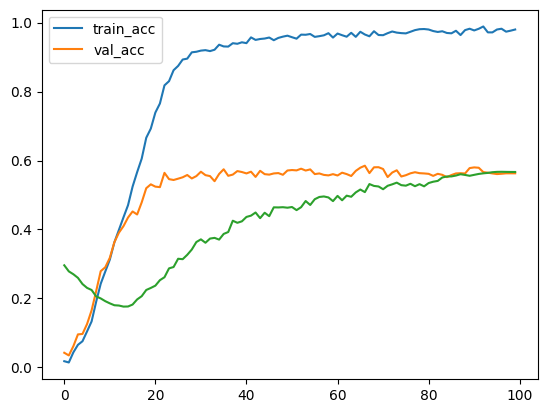

In [31]:
res = pd.DataFrame(res)
res[['train_acc','val_acc']].plot()
res['val_loss'].plot()
res['val_acc'].max()
res['val_acc'].tolist().index(res['val_acc'].max())

torch.Size([1, 55, 1])


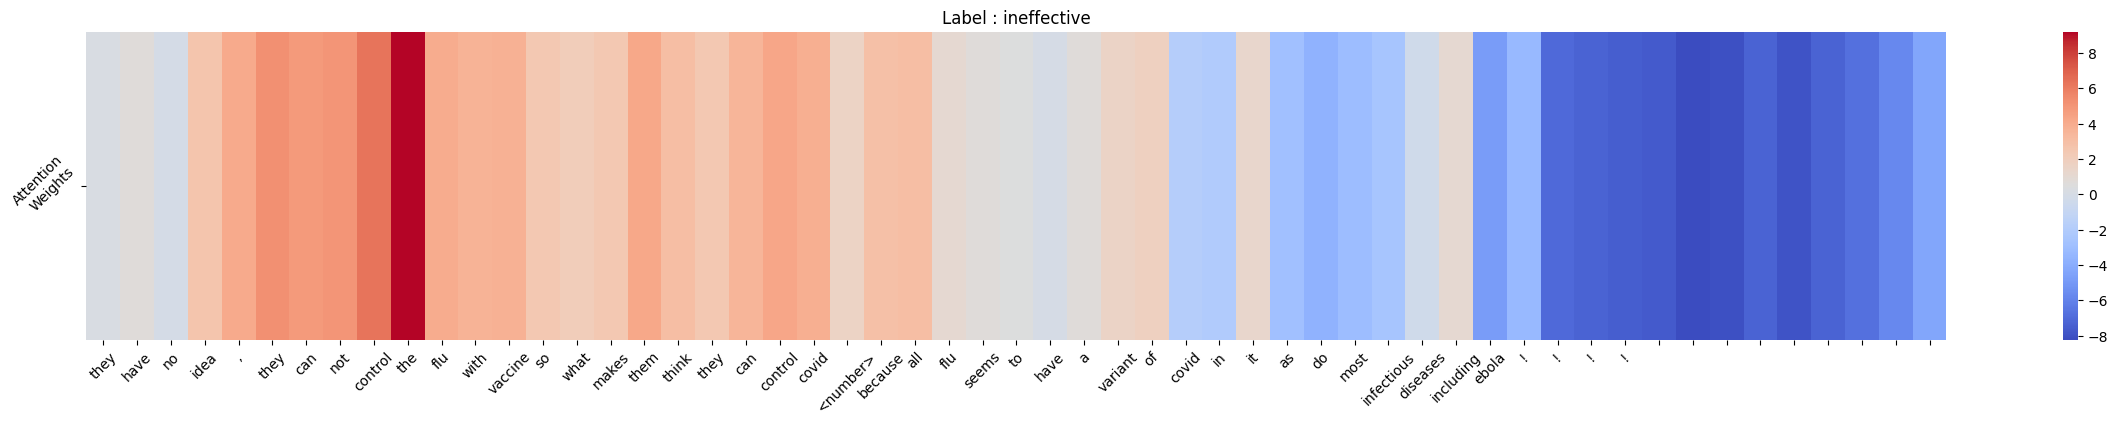

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_attention(sentence, attention_weights, ax, label_title):
    sns.heatmap(attention_weights.detach().numpy().reshape(1,-1), cmap='coolwarm', cbar=True, ax=ax)

    # Set the labels for the x-axis and y-axis
    ax.set_xticklabels(sentence, rotation=45)
    ax.set_yticklabels(['Attention\nWeights'], rotation=45)
    ax.set_title(f"Label : {label_title}")

    # Show the plot
    plt.show()

data_idx = 0
input_seq = train_dataset[data_idx][0]
trainer.model.load_state_dict(torch.load("./models/elmo_kaggle_preprocess_scheduler/best_model.pth",map_location=torch.device('cpu')))
trainer.model.eval()
embed = trainer.model.bi_gru(input_seq.unsqueeze(0))[0]
# print(embed.shape)
# F.softmax(self.attention(x), dim=1)
attention_weights = trainer.model.attention.attention(embed)
print(attention_weights.shape)
# Assume sentence is a list of strings representing the words in your sentence
sentence= ['they',
  'have',
  'no',
  'idea',
  ',',
  'they',
  'can',
  'not',
  'control',
  'the',
  'flu',
  'with',
  'vaccine',
  'so',
  'what',
  'makes',
  'them',
  'think',
  'they',
  'can',
  'control',
  'covid',
  '<number>',
  'because',
  'all',
  'flu',
  'seems',
  'to',
  'have',
  'a',
  'variant',
  'of',
  'covid',
  'in',
  'it',
  'as',
  'do',
  'most',
  'infectious',
  'diseases',
  'including',
  'ebola',
  '!',
  '!',
  '!',
  '!',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '']

label =  'ineffective'

fig, ax = plt.subplots(figsize=(30, 4))
visualize_attention(sentence, attention_weights, ax, label)


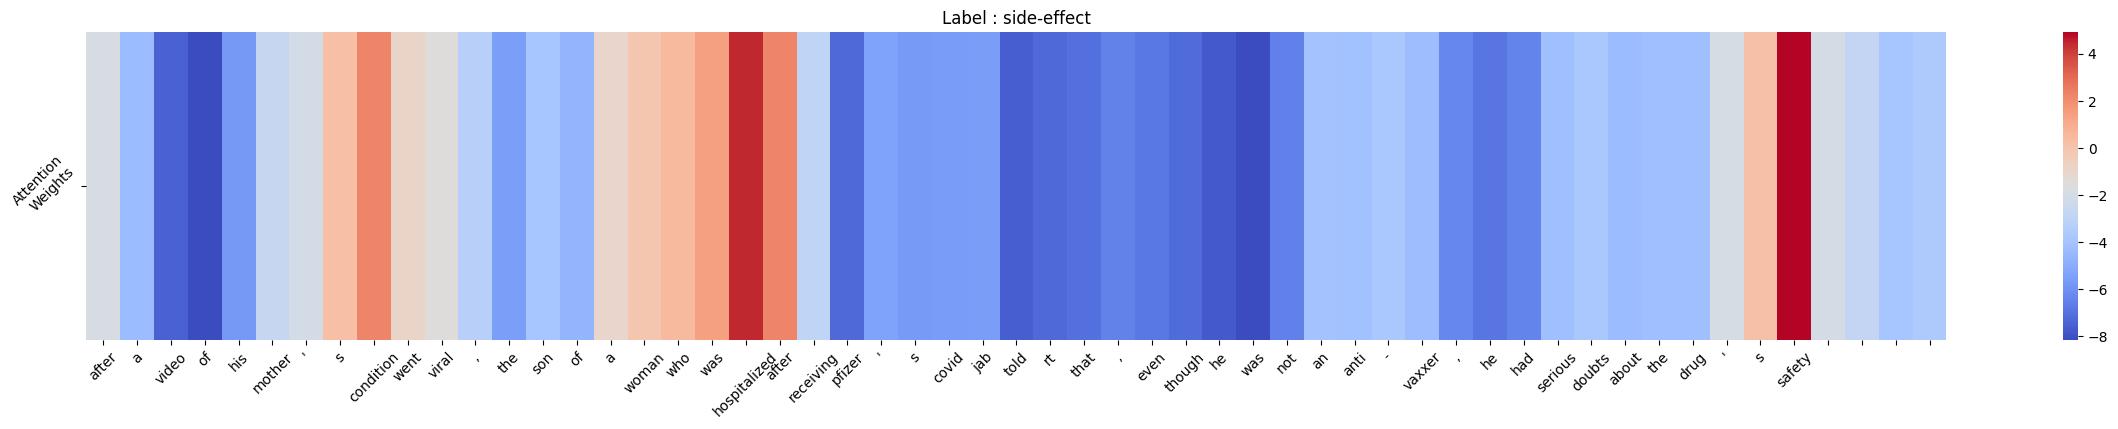

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_attention(sentence, attention_weights, ax, label_title):
    sns.heatmap(attention_weights.detach().numpy().reshape(1,-1), cmap='coolwarm', cbar=True, ax=ax)
    ax.set_xticklabels(sentence, rotation=45)
    ax.set_yticklabels(['Attention\nWeights'], rotation=45)
    ax.set_title(f"Label : {label_title}")
    plt.show()

data_idx = 5
input_seq = train_dataset[data_idx][0]
trainer.model.load_state_dict(torch.load("./models/elmo_kaggle_preprocess_scheduler/best_model.pth",map_location=torch.device('cpu')))
trainer.model.eval()
embed = trainer.model.bi_gru(input_seq.unsqueeze(0))[0]
attention_weights = trainer.model.attention.attention(embed)
sentence = ['after', 'a', 'video', 'of', 'his', 'mother', "'", 's', 'condition', 'went', 'viral', ',', 'the', 'son', 'of', 'a', 'woman', 'who', 'was', 'hospitalized', 'after', 'receiving', 'pfizer', "'", 's', 
             'covid', 'jab', 'told', 'rt', 'that', ',', 'even', 'though', 'he', 'was', 'not', 'an', 'anti', '-', 'vaxxer', ',', 'he', 'had', 'serious', 'doubts', 'about', 'the', 'drug', "'", 's', 'safety',"","","",""]
label = 'side-effect'
fig, ax = plt.subplots(figsize=(30, 4))
visualize_attention(sentence, attention_weights, ax, label)
